In [1]:
#@title Setup model

import os
os.chdir('/content')

!unzip stylegan2.zip

!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force

Archive:  stylegan2.zip
   creating: stylegan2/
  inflating: __MACOSX/._stylegan2    
  inflating: stylegan2/.DS_Store     
  inflating: __MACOSX/stylegan2/._.DS_Store  
   creating: stylegan2/op/
 extracting: stylegan2/__init__.py   
  inflating: stylegan2/model.py      
  inflating: __MACOSX/stylegan2/._model.py  
  inflating: stylegan2/op/fused_act.py  
  inflating: stylegan2/op/upfirdn2d.cpp  
  inflating: stylegan2/op/__init__.py  
  inflating: stylegan2/op/upfirdn2d.py  
  inflating: stylegan2/op/fused_bias_act.cpp  
  inflating: stylegan2/op/upfirdn2d_kernel.cu  
  inflating: stylegan2/op/fused_bias_act_kernel.cu  
--2023-03-28 05:15:27--  https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://objects.githubusercontent.com/github-production-release-asset-2e65be/1335132/d2

In [2]:
#@title import modules

import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms

%pip install -q ipywidgets
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from stylegan2.model import Generator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.1 MB/s eta 0:00:00


In [3]:
#download checkpoint
#@title Setup files downloader
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

download_with_pydrive = True 

CODE_DIR = ''
class Downloader(object):
    def __init__(self, use_pydrive):
        self.use_pydrive = use_pydrive
        current_directory = os.getcwd()
        self.save_dir = os.path.join(os.path.dirname(current_directory), CODE_DIR, "pretrained_models")
        os.makedirs(self.save_dir, exist_ok=True)
        print(self.save_dir)
        if self.use_pydrive:
            self.authenticate()

    def authenticate(self):
        auth.authenticate_user()
        gauth = GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        self.drive = GoogleDrive(gauth)

    def download_file(self, file_id, file_name):
        file_dst = f'{self.save_dir}/{file_name}'
        if os.path.exists(file_dst):
            print(f'{file_name} already exists!')
            return
        if self.use_pydrive:
            downloaded = self.drive.CreateFile({'id':file_id})
            downloaded.FetchMetadata(fetch_all=True)
            downloaded.GetContentFile(file_dst)
        else:
            !gdown --id $file_id -O $file_dst

downloader = Downloader(download_with_pydrive)
id = '1EM87UquaoQmk17Q8d5kYIAHqu0dkYqdT'
file_name = 'stylegan2-ffhq-config-f.pt'

downloader.download_file(id, file_name)


/pretrained_models


In [15]:
class Generator_Wrapper:
  def __init__(self):
    self.model = Generator(1024, 512, 8).to('cuda')
    self.init_weights()
    self.face_pool = torch.nn.AdaptiveAvgPool2d((256, 256))
  def init_weights(self):
    self.model.load_state_dict(torch.load('../pretrained_models/stylegan2-ffhq-config-f.pt')['g_ema'])

  def generate_image(self, input = None, input_is_latent = False, num_images = 1):
    if input is None:
      input = torch.randn((num_images, 512)).cuda()
    
    with torch.no_grad():
      out, latents = self.model([input], input_is_latent = input_is_latent, return_latents = True)
      out = self.face_pool(out)
      return out, latents

  def tensor2image(self, out):
    #TODO: given tensor of size (B, 3, 256, 256) in the range(-1, 1) return a PIL Image with size (256, 256 * B, 3)
    out = out.permute(0, 2, 3, 1).clamp(-1, 1).detach().cpu().numpy()
    out = ((out + 1) * 127.5).astype('uint8')
    out = np.concatenate(out, axis = 1)
    return Image.fromarray(out)

In [16]:
G = Generator_Wrapper()
images, latents = G.generate_image(num_images = 4)

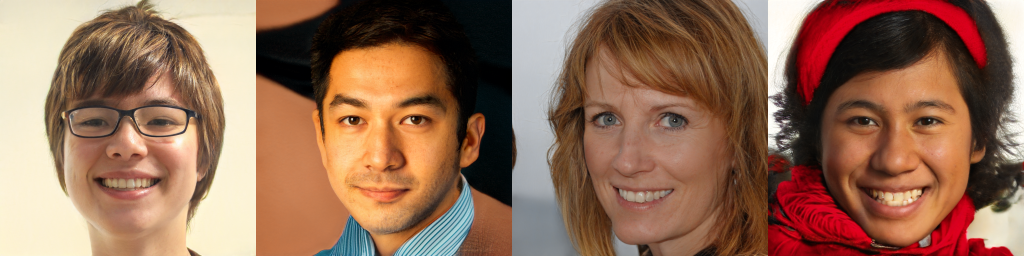

In [17]:
G.tensor2image(images)

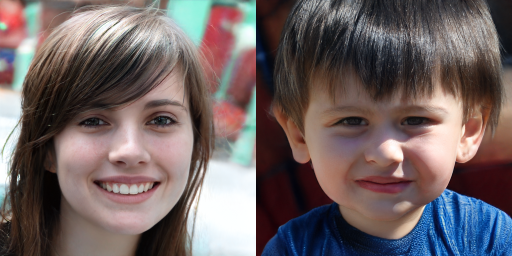

In [21]:
#@title Latent interpolation

#TODO: generate two images with latents and visualize
images, latents = G.generate_image(num_images = 2)
G.tensor2image(images)

In [32]:
#interpolate two latents
def interpolate_latents(interpolate_scale):
  #TODO: interpolate between two latents generated above. interpolate_scale is the interpolation coefficient
  new_latent = latents[0] * (interpolate_scale) + latents[1] * (1 - interpolate_scale)
  image, _ = G.generate_image(new_latent.unsqueeze(0), input_is_latent = True)
  image = G.tensor2image(image)
  return image

In [33]:
#make slider and show
interact(interpolate_latents, interpolate_scale=widgets.FloatSlider(0.5, min=0, max=1., step=0.05))

interactive(children=(FloatSlider(value=0.5, description='interpolate_scale', max=1.0, step=0.05), Output()), …

<function __main__.interpolate_latents(interpolate_scale)>

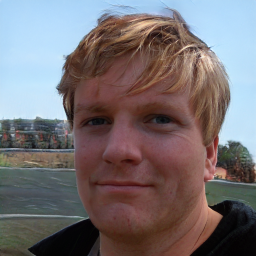

In [37]:
#@title Mixing latents

#TODO: make a base image with latents and show
base_image, base_latents = G.generate_image(num_images = 1)
G.tensor2image(base_image)

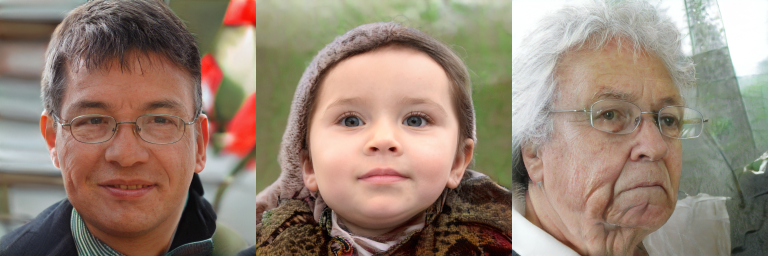

In [43]:
#TODO: make 3 new faces. They will be edited using base latent
target_images, target_latents = G.generate_image(num_images = 3)
G.tensor2image(target_images)

In [49]:
def mix_latents(mixing_point):
  #TODO: mix latents. the first mixing_point blocks should get the latent from base_latent and the rest come from target_latents
  edited_latents = target_latents.clone()
  edited_latents[:, :mixing_point, :] = base_latents[:, :mixing_point, :]
  edited_images, _ = G.generate_image(edited_latents, input_is_latent = True)
  return G.tensor2image(edited_images)
 

In [50]:
interact(mix_latents, mixing_point=widgets.IntSlider(0, min=0, max=18, step=1))

interactive(children=(IntSlider(value=0, description='mixing_point', max=18), Output()), _dom_classes=('widget…

<function __main__.mix_latents(mixing_point)>